In [195]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
import h5py

## Load Data

In [196]:
data = pd.read_hdf("data.h5")

In [198]:
data = data.loc[data["date_key"] < "2019-01-01"]

In [200]:
# Drop NA col for now until we get Wendy's imputed data
data = data.dropna(axis=1)

#### Aside: X and Y are supposed to be some transformation of grid_lat and grid_lon? What do they represent?

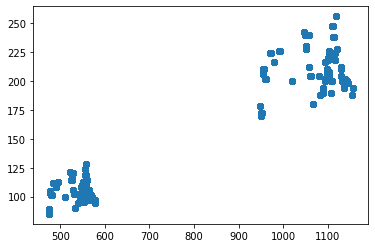

In [78]:
plt.scatter(data["x"], data["y"])
plt.show()

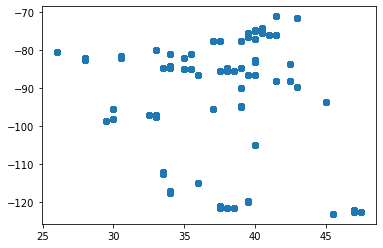

In [81]:
plt.scatter(data["grid_lat"], data["grid_lon"])
plt.show()

## Exploring Autocorrelation of Impact Scores (target var)

In [372]:
# Limit time range
impact = data.loc[(data["date_key"] < "2019-01-01") & (data["Time"] == 0)]

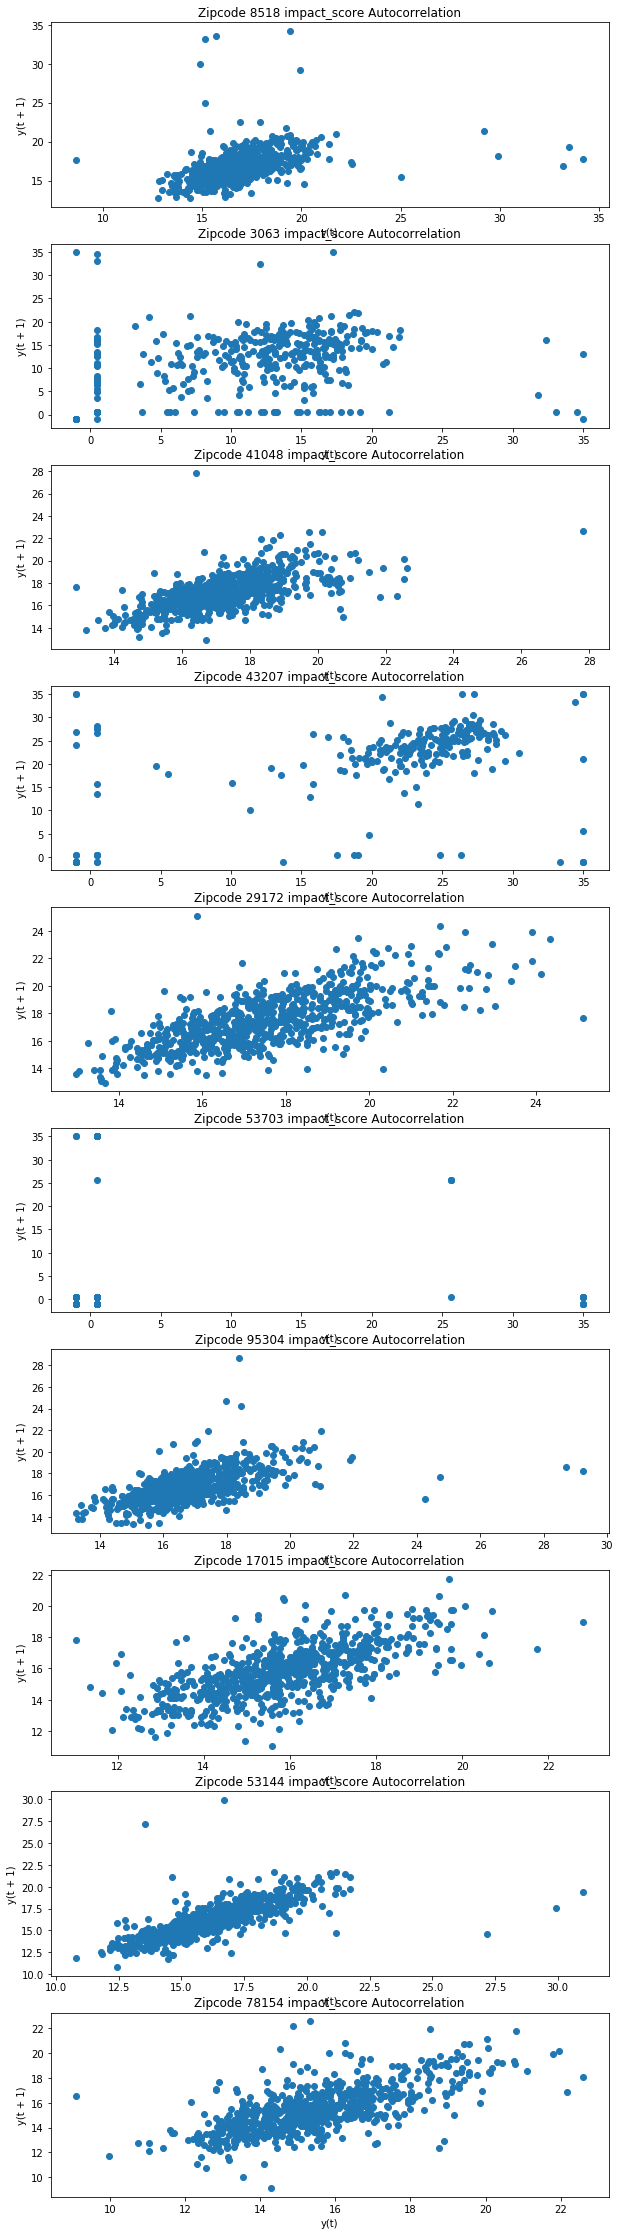

In [390]:
zips = [8518, 3063, 41048, 43207, 29172, 53703, 95304, 17015, 53144, 78154]

def plot_autocorr(zips, col):
    fig, ax = plt.subplots(10, 1, figsize=(10, 40))
    
    for i, zip in enumerate(zips):
        lag_plot(impact.loc[impact["zip5"] == zip].sort_values(by = ["date_key"])[col], ax=ax[i])
        ax[i].set_title("Zipcode " + str(zip) + " " + col + " Autocorrelation")
    
    plt.show()
    
plot_autocorr(zips, "impact_score")

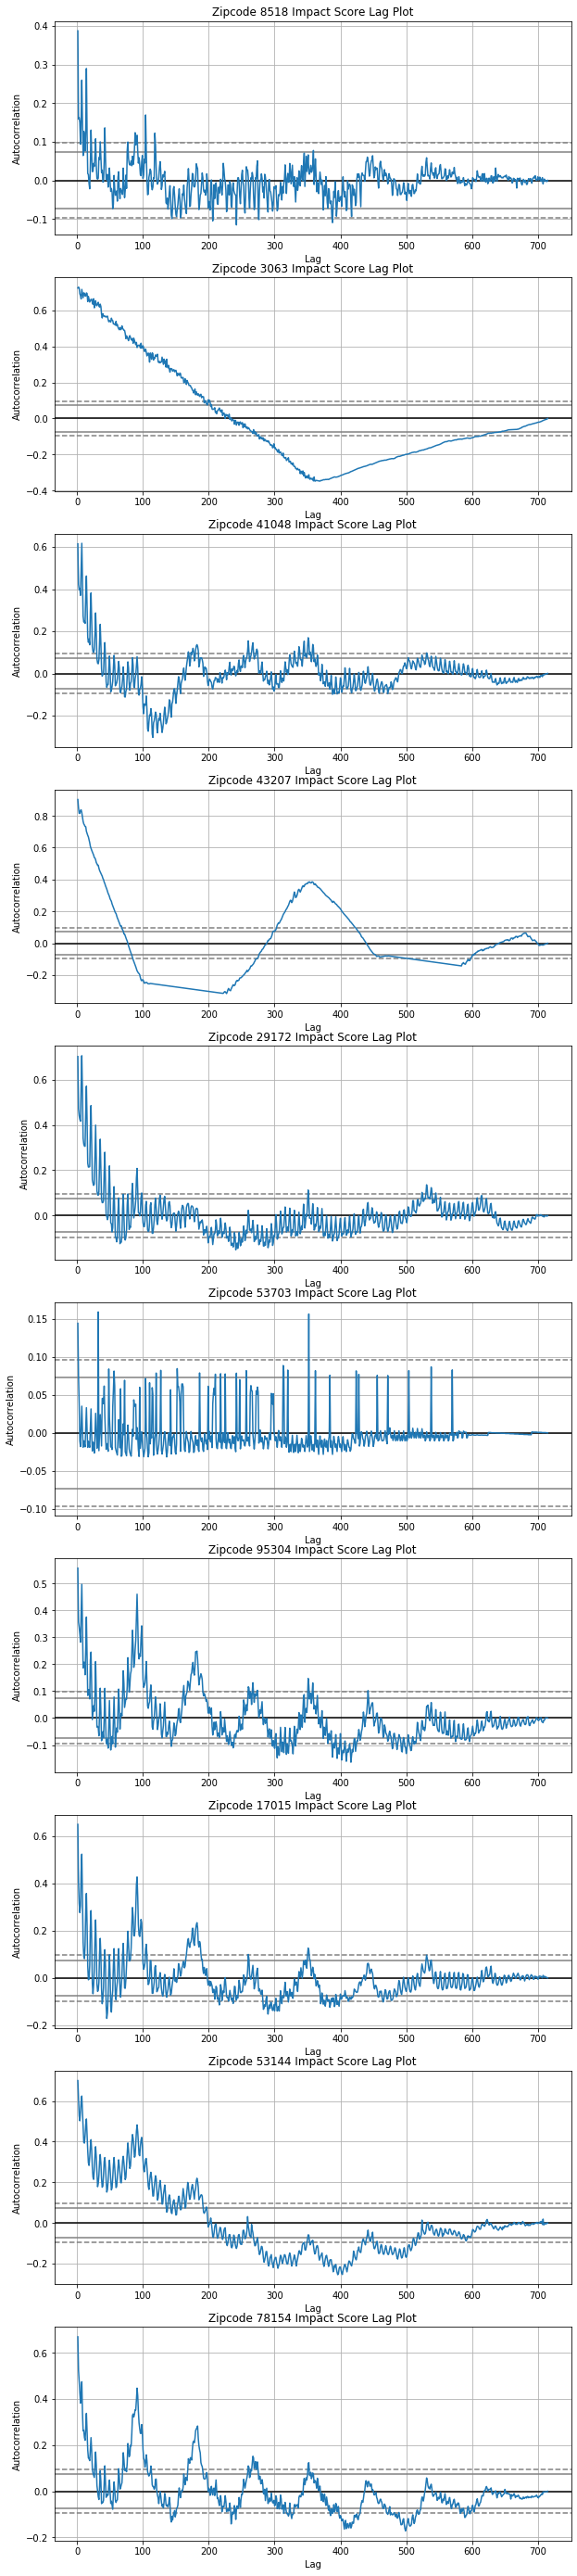

In [399]:
fig, ax = plt.subplots(10, 1, figsize=(10, 50))
for i, zip in enumerate(zips):
    autocorrelation_plot(impact.loc[impact["zip5"] == zip].sort_values(by = ["date_key"])["impact_score"], ax=ax[i])
    ax[i].set_title("Zipcode " + str(zip) + " Impact Score Lag Plot")
plt.show()

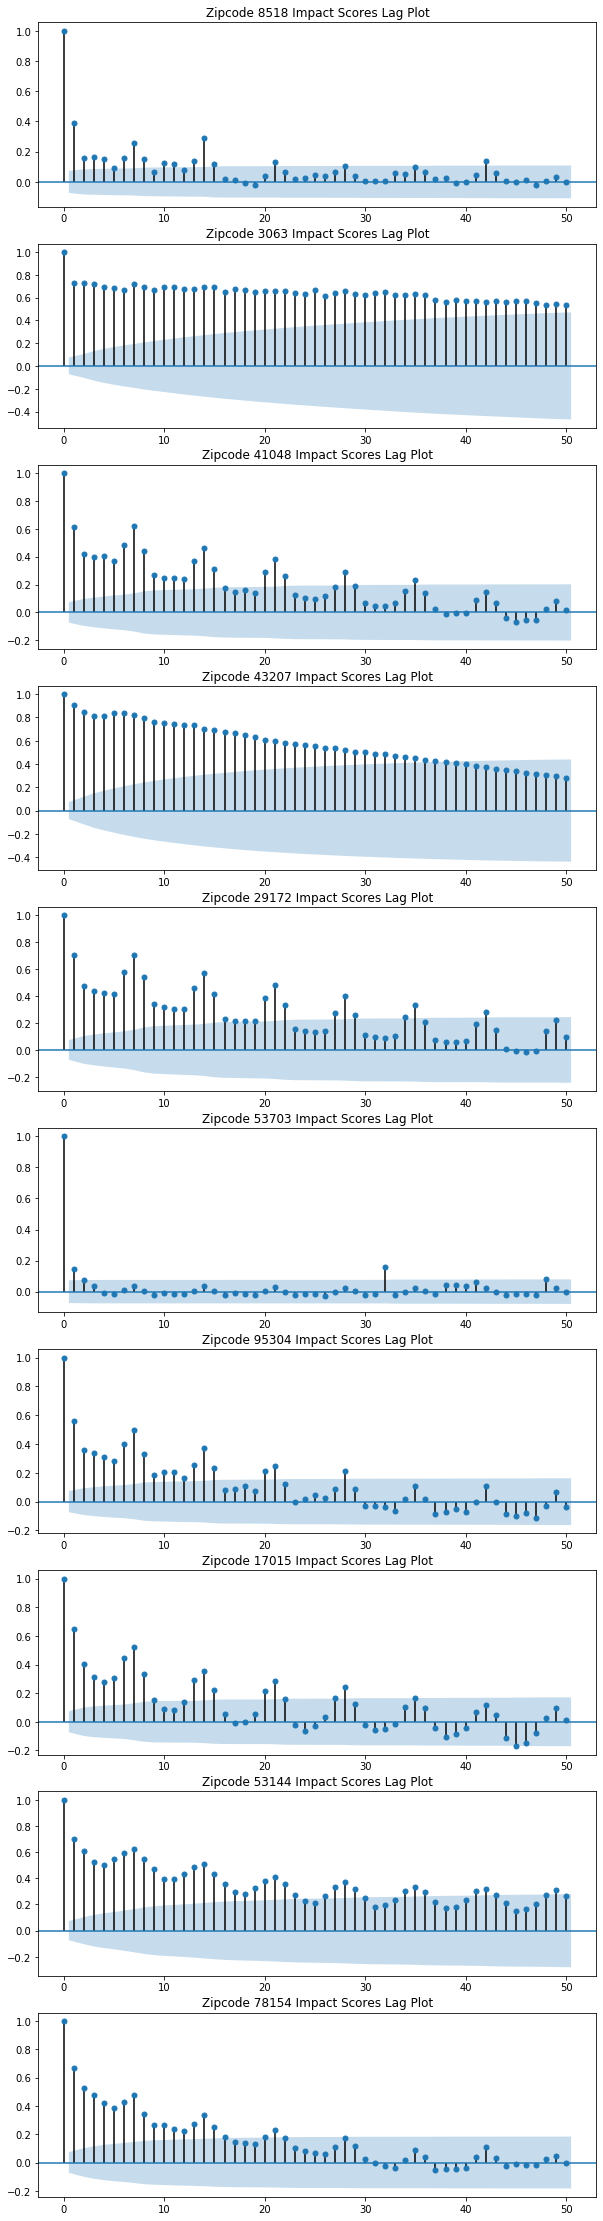

In [400]:
fig, ax = plt.subplots(10, 1, figsize=(10, 40))

for i, zip in enumerate(zips):
    plot_acf(impact.loc[impact["zip5"] == zip].sort_values(by = ["date_key"])["impact_score"], lags=50, ax=ax[i])
    ax[i].set_title("Zipcode " + str(zip) + " Impact Scores Lag Plot")
plt.show()

For many zips there is a cycle in the autocorrelation. The previous day is highly autocorrelated and the same day one week ago (lag = 7) is high correlated. In some zips like 53144 this pattern is very regular.

The variance and autocorrelation of impact score varies drastically from zipcode to zipcode. Let's try to visualize the impact scores for each zip over time to get a better idea why this is.

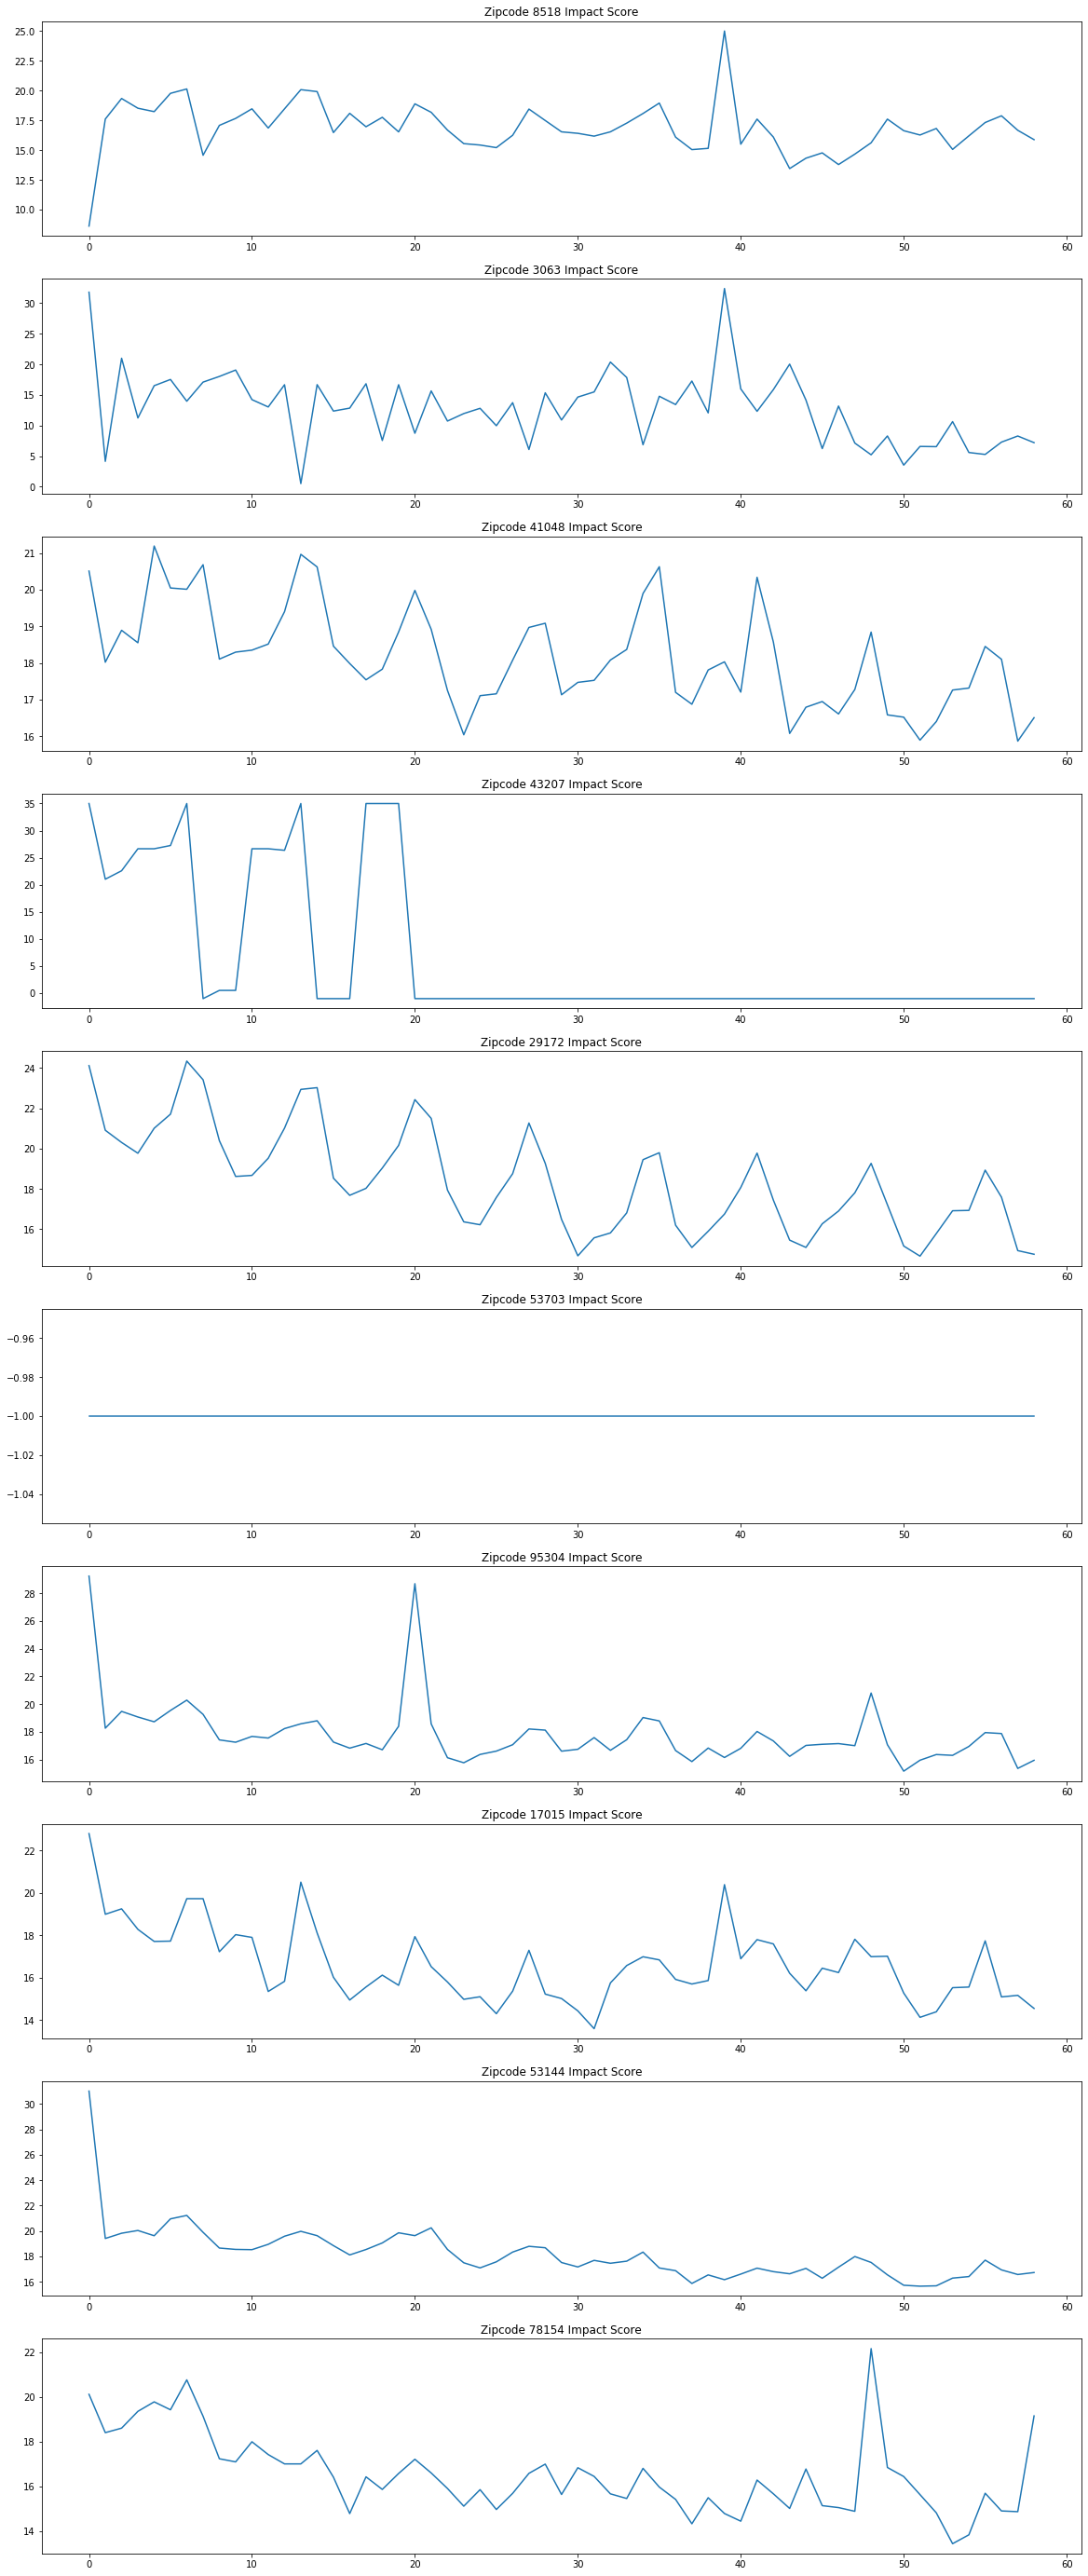

In [401]:
impact_limited = impact.loc[impact["date_key"] < "2017-03-01"]
fig, ax = plt.subplots(10, 1, figsize=(20, 50))
n = impact_limited.shape[0]
for i, zip in enumerate(zips):
    impact_i = impact_limited.loc[(impact_limited["zip5"] == zip)]["impact_score"]
    ax[i].plot(np.arange(impact_i.shape[0]), impact_i)
    ax[i].set_title("Zipcode " + str(zip) + " Impact Score")

plt.show()

For zips 43207 and 3063, the high autocorrelation was occuring because of the -1 values in impact score which we believe represent missing data. So this autocorrelation is not truly a valid trend.

For the other zips, some have a pretty defined cyclical trend while others are more much more random.

If we do consider adding autoregressive terms for impact_score, to predict impact score at time t, we should consider impact scores at time t-1 and t-7 as features in our regression. The big problem this poses is that we don't have impact score for all of 2019, so we would be using our own projected estimates as regressors. This may result in compounding error.

## Exploring Autocorrelation of Weather Variables

In [242]:
identifiers = ["grid_lat", "grid_lon", "x", "Time", "date_key", "day", "month", "year", \
               "y", "Region", "USR", "Weekday", "density", "state", "impact_score", "zip5"]
garbage = ["ForecastRange", "Ice_cover_surface"]

weather = set(data.columns.tolist()) - set(identifiers) - set(garbage)

In [243]:
weather

{'5_Wave_Geopotential_Height_isobaric',
 'Absolute_vorticity_isobaric',
 'Apparent_temperature_height_above_ground',
 'Best_4_layer_Lifted_Index_surface',
 'Cloud_mixing_ratio_isobaric',
 'Cloud_water_entire_atmosphere_single_layer',
 'Convective_available_potential_energy_pressure_difference_layer',
 'Convective_available_potential_energy_surface',
 'Convective_inhibition_pressure_difference_layer',
 'Convective_inhibition_surface',
 'Dewpoint_temperature_height_above_ground',
 'Geopotential_height_highest_tropospheric_freezing',
 'Geopotential_height_isobaric',
 'Geopotential_height_maximum_wind',
 'Geopotential_height_surface',
 'Geopotential_height_tropopause',
 'Geopotential_height_zeroDegC_isotherm',
 'ICAO_Standard_Atmosphere_Reference_Height_maximum_wind',
 'ICAO_Standard_Atmosphere_Reference_Height_tropopause',
 'Land_cover_0__sea_1__land_surface',
 'MSLP_Eta_model_reduction_msl',
 'Ozone_Mixing_Ratio_isobaric',
 'Per_cent_frozen_precipitation_surface',
 'Planetary_Boundary_La

In [204]:
# Limit time range ()
temps = data.loc[data["date_key"] < "2018-01-01"]

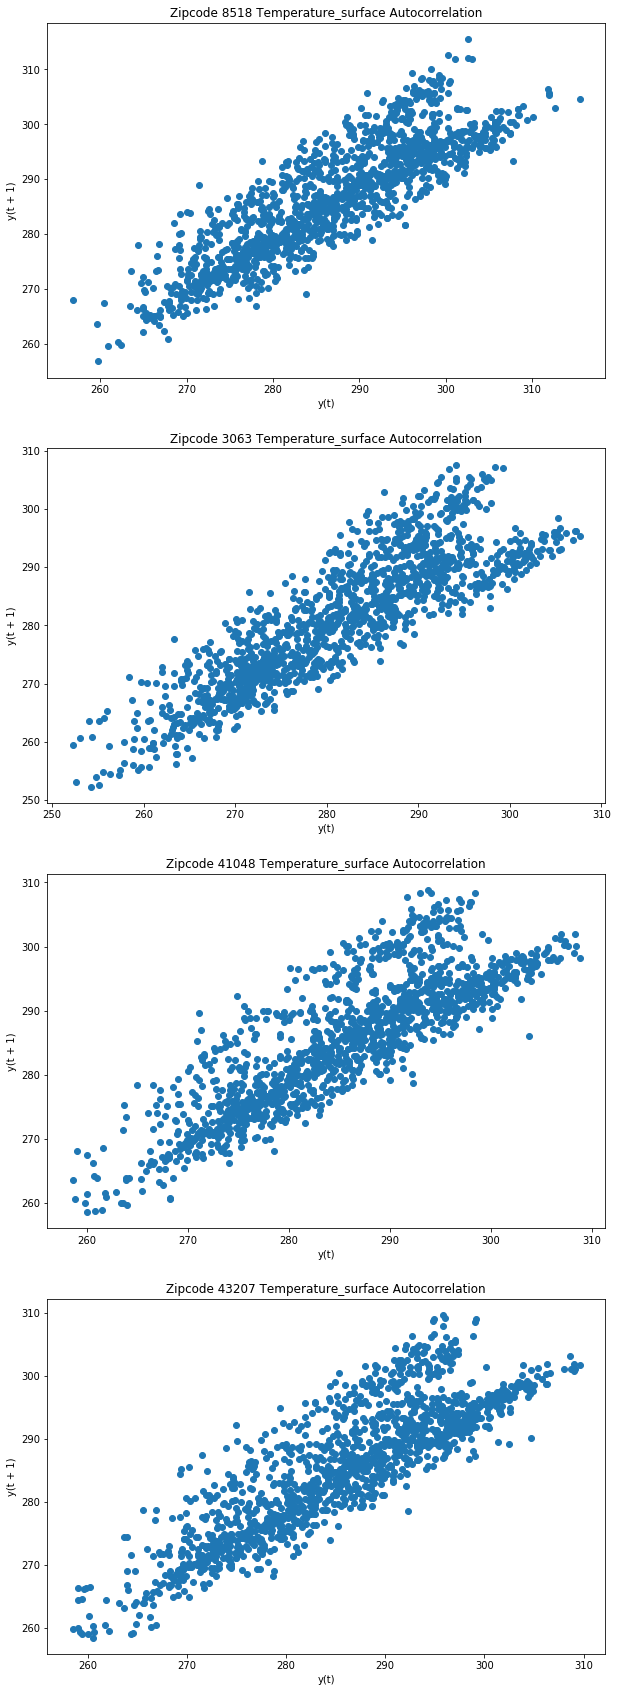

In [270]:
zips = [8518, 3063, 41048, 43207]

def plot_autocorr(zips, col):
    fig, ax = plt.subplots(4, 1, figsize=(10, 30))
    
    for i, zip in enumerate(zips):
        lag_plot(temps.loc[temps["zip5"] == zip].sort_values(by = ["date_key", "Time"])[col], ax=ax[i])
        ax[i].set_title("Zipcode " + str(zip) + " " + col + " Autocorrelation")
    
    plt.show()
    
plot_autocorr(zips, "Temperature_surface")

There definately appears to be a autocorrelation for temperature. Let's figure out the time period.

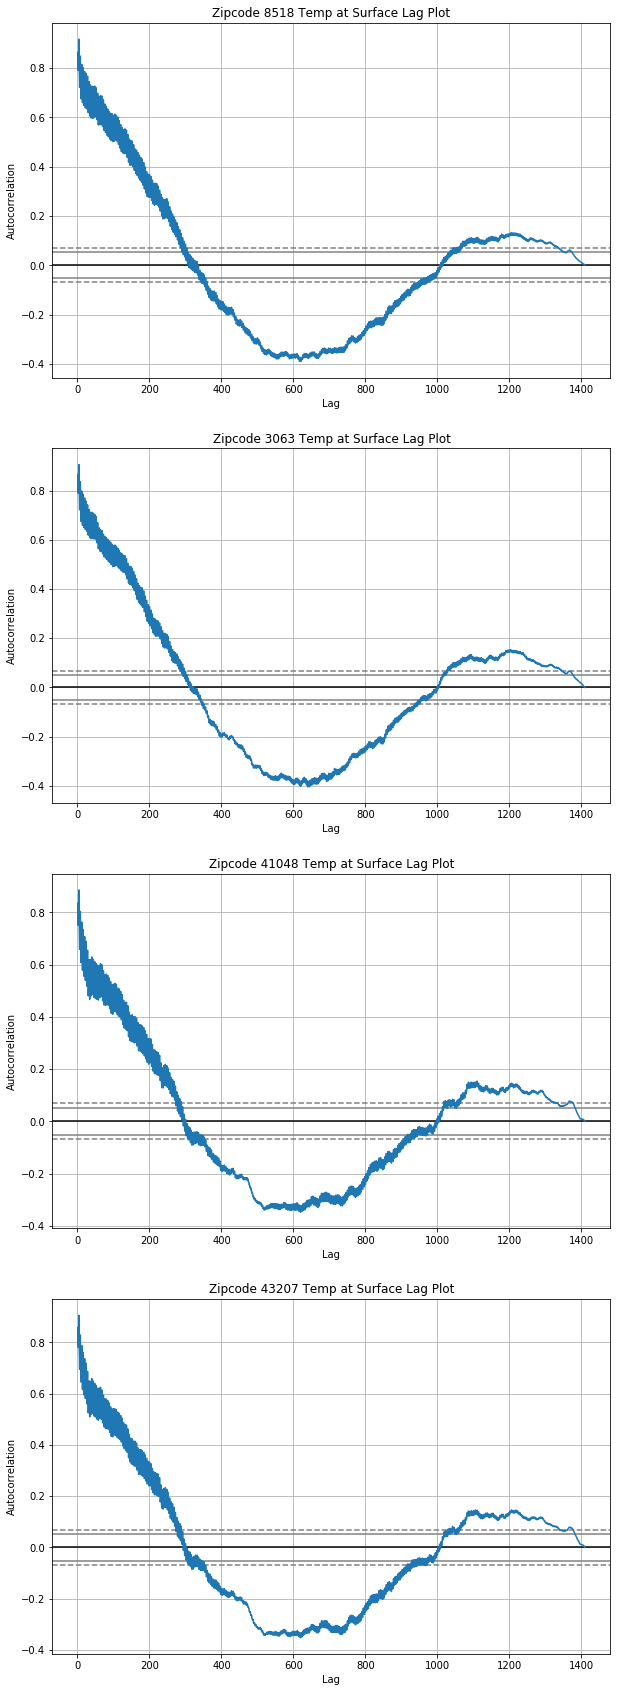

In [206]:
zips = [8518, 3063, 41048, 43207]
fig, ax = plt.subplots(4, 1, figsize=(10, 30))

for i, zip in enumerate(zips):
    autocorrelation_plot(temps.loc[temps["zip5"] == zip].sort_values(by = ["date_key", "Time"])["Temperature_surface"], ax=ax[i])
    ax[i].set_title("Zipcode " + str(zip) + " Temp at Surface Lag Plot")
plt.show()

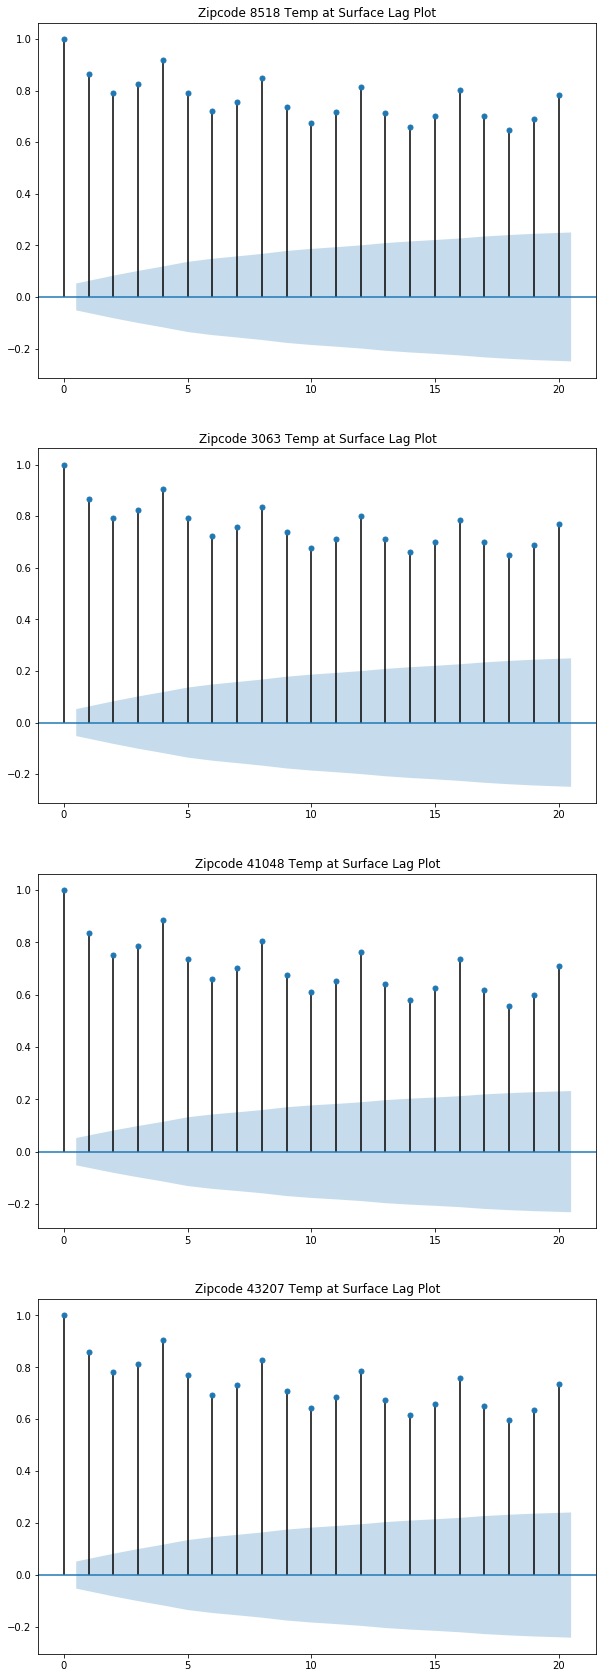

In [207]:
zips = [8518, 3063, 41048, 43207]
fig, ax = plt.subplots(4, 1, figsize=(10, 30))

for i, zip in enumerate(zips):
    plot_acf(temps.loc[temps["zip5"] == zip].sort_values(by = ["date_key", "Time"])["Temperature_surface"], lags=20, ax=ax[i])
    ax[i].set_title("Zipcode " + str(zip) + " Temp at Surface Lag Plot")
plt.show()

It appears temp is most autocorrelated to the temp yesterday at the same time interval which is not surprising.

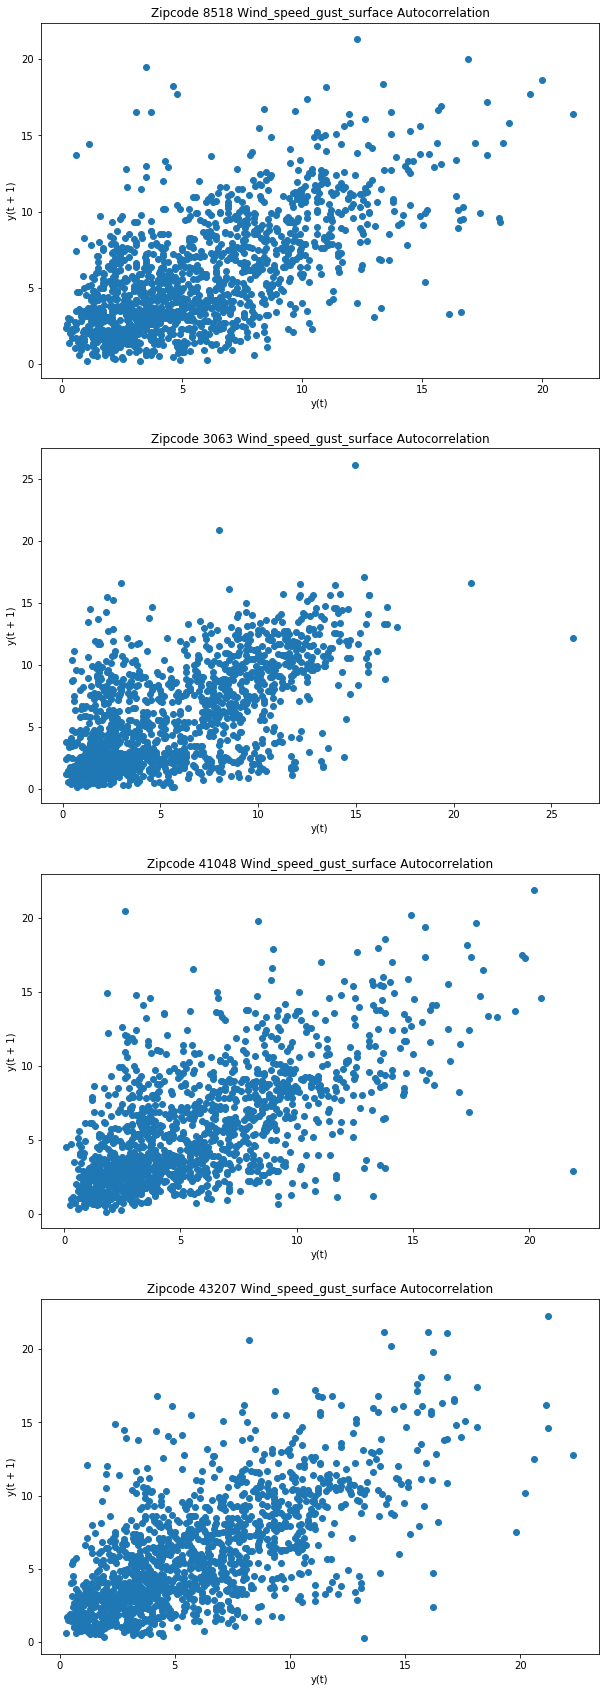

In [271]:
plot_autocorr(zips, "Wind_speed_gust_surface")

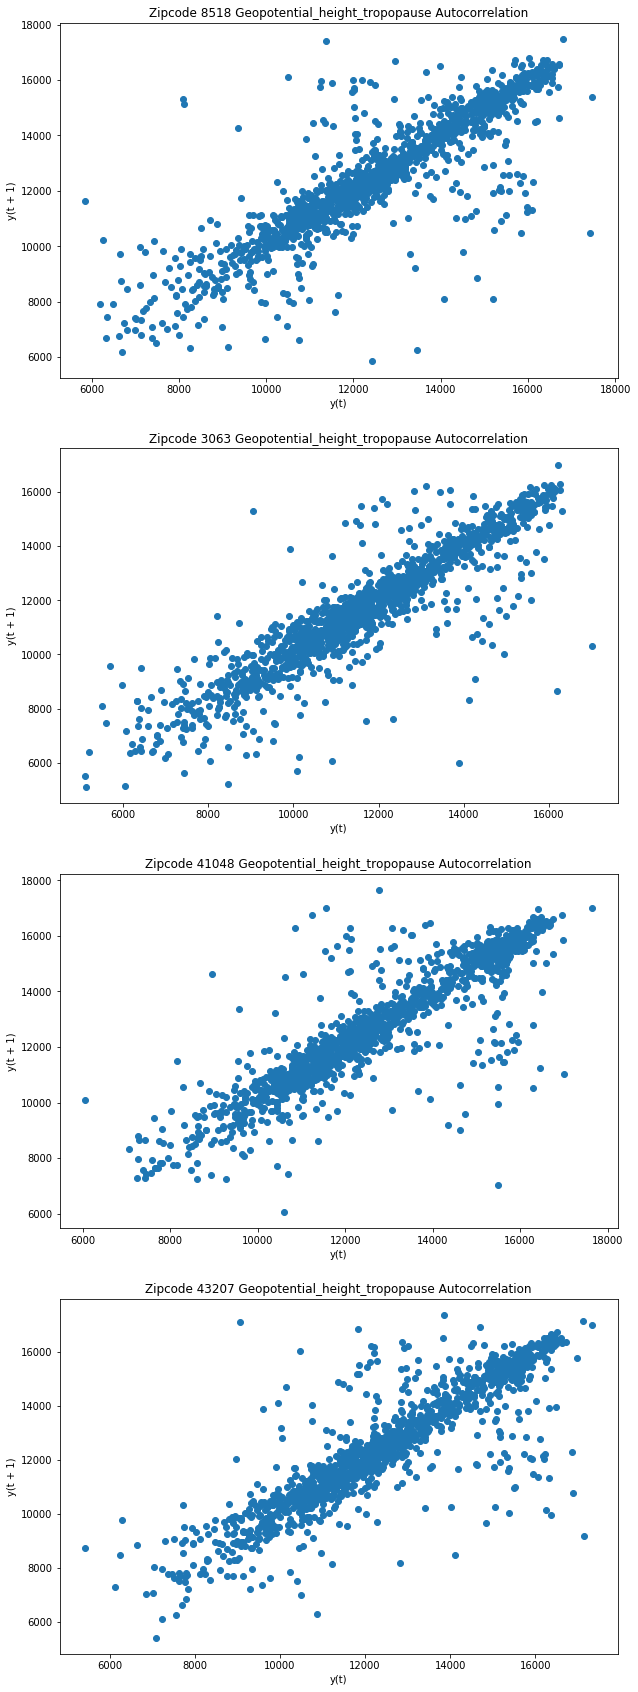

In [272]:
plot_autocorr(zips, "Geopotential_height_tropopause")

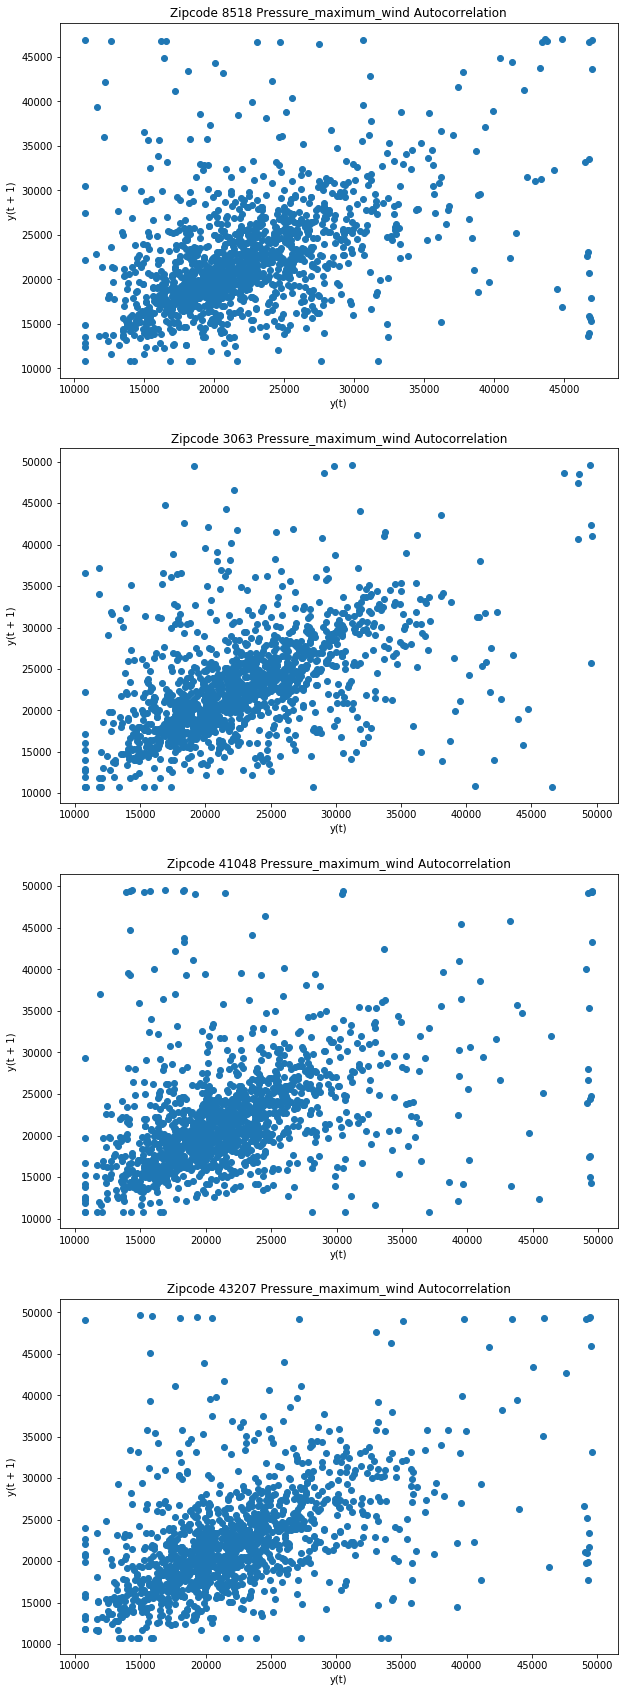

In [273]:
plot_autocorr(zips, "Pressure_maximum_wind")

So obviously time intervals when it comes to weather are NOT independent and several weather predictor variables are very clearly autocorrelated. But this correlation is not what we are interested in. We want to understand if lagged predictors are correlated with our response varaible impact_socre.

## Cross Correlation between Lagged Predictors and Response

We are interested in is cross correlation between lagged predictors and response, not autocorrelation of predictors. So for each predictor I find relevant, I will look at the correlation coefficient between the impact_socre and the lagged predictor. This will help inform us if we need to include lagged predictors in our model.

### Cross correlations for zip 8518

In [415]:
# limit dataframe to one zipcode
zip8518 = data.loc[data["zip5"] == 8518]

In [417]:
sample = list(weather)

In [418]:
def lagged_corr(df):
    max_lag = 29
    lagged_correlation = pd.DataFrame.from_dict(
        {x: [df["impact_score"].corr(df[x].shift(t)) for t in range(max_lag)] for x in sample})
    return lagged_correlation

lagged_correlation_8518 = lagged_corr(zip8518)

In [419]:
lagged_correlation_8518

Relative_humidity_zeroDegC_isotherm  \
0                              0.076743   
1                              0.063829   
2                              0.049521   
3                              0.038758   
4                              0.013978   
5                             -0.007602   
6                             -0.022053   
7                             -0.039048   
8                             -0.047049   
9                             -0.039591   
10                            -0.033829   
11                            -0.026028   
12                            -0.008410   
13                             0.000143   
14                             0.000805   
15                            -0.005124   
16                            -0.003969   
17                            -0.003240   
18                            -0.003887   
19                            -0.007175   
20                            -0.016739   
21                            -0.024269   
22                            -0.019731   
23                            -0.005148   
24                             0.009885   
25                             0.018133   
26                             0.024673   
27                             0.019252   
28                             0.002304   

    Relative_humidity_pressure_difference_layer  \
0                                      0.043883   
1                                      0.015636   
2                                      0.002854   
3                                     -0.010292   
4                                     -0.026570   
5                                     -0.039594   
6                                     -0.048766   
7                                     -0.057399   
8                                     -0.065752   
9                                     -0.072652   
10                                    -0.071259   
11                                    -0.057074   
12                                    -0.045443   
13                                    -0.035696   
14                                    -0.029206   
15                                    -0.030738   
16                                    -0.033837   
17                                    -0.039475   
18                                    -0.044336   
19                                    -0.050346   
20                                    -0.051931   
21                                    -0.058452   
22                                    -0.064487   
23                                    -0.058294   
24                                    -0.052812   
25                                    -0.040624   
26                                    -0.027819   
27                                    -0.022583   
28                                    -0.024525   

    Dewpoint_temperature_height_above_ground  \
0                                  -0.049430   
1                                  -0.050603   
2                                  -0.050408   
3                                  -0.051932   
4                                  -0.053875   
5                                  -0.056238   
6                                  -0.060694   
7                                  -0.065368   
8                                  -0.070464   
9                                  -0.071892   
10                                 -0.071883   
11                                 -0.067489   
12                                 -0.063452   
13                                 -0.060671   
14                                 -0.055815   
15                                 -0.055090   
16                                 -0.056592   
17                                 -0.061659   
18                                 -0.067102   
19                                 -0.073242   
20                                 -0.076299   
21                                 -0.077190   
22                                 -0.076970   
23                            

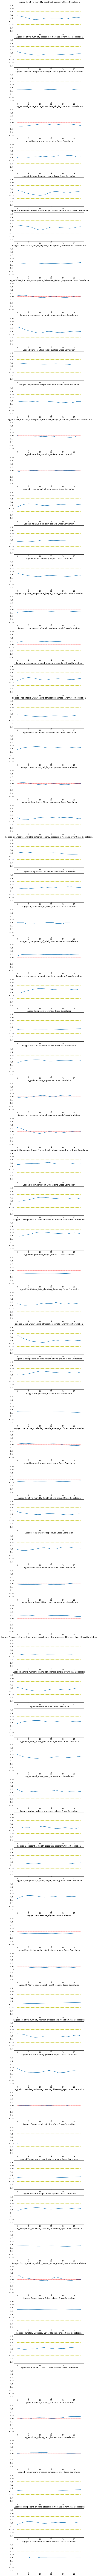

In [434]:
# Plot corr for each feature
def plot_lagged_corr(lagged_correlation):
    n = len(sample)
    fig, ax = plt.subplots(n, 1, figsize=(8, 300))
    for i, col in enumerate(sample):
        ax[i].plot(np.arange(29), lagged_correlation[col])
        ax[i].set_title("Lagged " + col + " Cross Correlation")
        ax[i].set_ylim([-0.45, 0.45])

        # Add threshold at 0.15
        ax[i].plot(np.arange(29), np.ones(29)*0.2, 'y--')
        ax[i].plot(np.arange(29), np.ones(29)*-0.2, 'y--')
        ax[i].plot(np.arange(29), np.zeros(29), 'r--', linewidth=0.5)
        

plot_lagged_corr(lagged_correlation_8518)

### Cross correlations for zip 41048

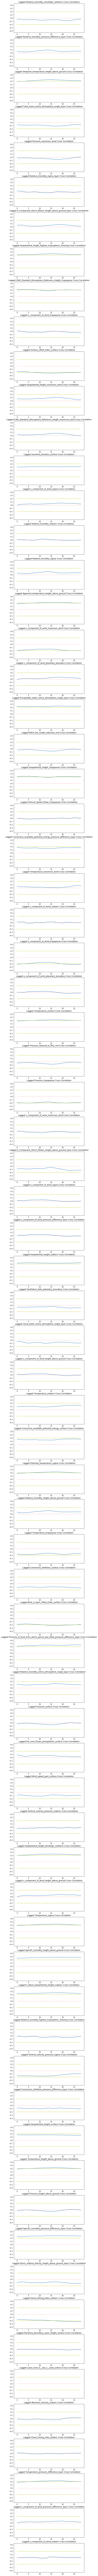

In [435]:
zip41048 = data.loc[data["zip5"] == 41048]
lagged_correlation_41048 = lagged_corr(zip41048)
plot_lagged_corr(lagged_correlation_41048)

### Cross correlations for zip 43207

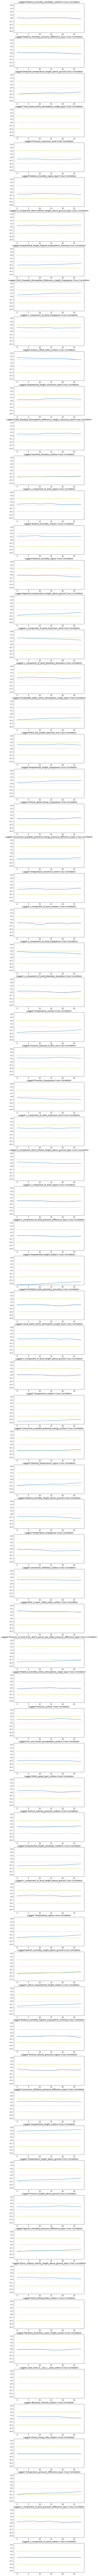

In [436]:
zip43207 = data.loc[data["zip5"] == 43207]
lagged_correlation_43207 = lagged_corr(zip43207)
plot_lagged_corr(lagged_correlation_43207)

Less significant correlations fall between the yellow dashed lines and more significant correlations fall outside of these lines. Most these correlations fall between these two lines which means that our predictors in general don't have a high correlation with our target (impact_scores). 

But also the blue lines are relativitly flat across all 50 lag points. This indicates that adding lag weather features will not improve our modeling dramamtically. Our initial thought was if it snows heavily on Monday but doesn't snow on Tuesday, the impact score Tuesday will be affected by the weather on Monday rather than Tuesday. This doesn't seem to be true. Including lags of the predictors in linear models will not remarkably improve performance.

# Summary Discussion

One big caveat is that correlation only measure linear relationships between variables.  It is very much possible that these lagged predictors or lagged response are non-linearly "correlated" to the response and that relatinoship is not being captured here. Testing for non-linear auto or cross correlation relationships is much more difficult. The best way to test might be during our modeling stage. Whatever nonlinear model we choose, we should add lags and see if it improves validation accuracy.